Feature detection

Marius Dufraisse

In [437]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris
from skimage.transform import rotate, rescale, SimilarityTransform, resize, warp, AffineTransform, ProjectiveTransform
from skimage.color import rgb2lab
from skimage.measure import block_reduce
from scipy.spatial.distance import pdist, squareform

In [237]:
def point_map(points, color=(1,0,0)):
    # Return an RGBA image where the points have alpha=1 and RGB = color
    disp = np.zeros((*points.shape, 4))
    for i in range(3):
        disp[:,:,i] = color[i]
    disp[:,:,3] = points
    return disp

In [314]:
img = plt.imread("val.png")
img = rgb2lab(img)[:,:,0]

imgr = resize(rotate(img, 90,resize=False),img.shape)

squares = np.zeros((256,256))
for (i,j) in np.ndindex(4,4):
    squares[64*i:64*i+32,64*j:64*j+32] = 1
    squares[64*i+32:64*i+64,64*j+32:64*j+64] = 1



## Harris detector ##

In [276]:
a = corner_harris(img)
ar = corner_harris(imgr)

In [277]:
def threshold(img, threshold, fixed = False):
    if not fixed:
        threshold = threshold * img.max()
    return img >= threshold

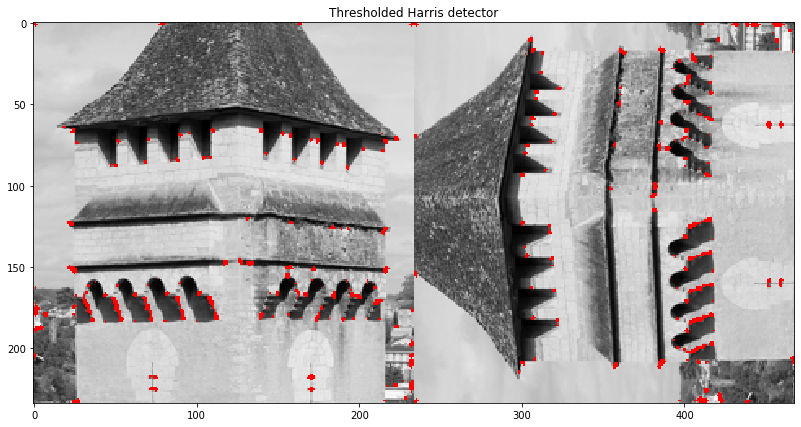

In [278]:
plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgr)),cmap='gray')

plt.imshow(point_map(np.hstack((threshold(a,0.1,fixed=False),threshold(ar,0.1,fixed=False)))))
plt.title("Thresholded Harris detector")
plt.show()


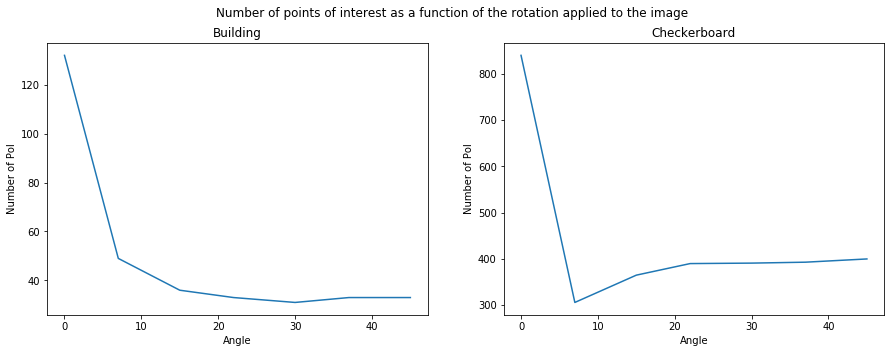

In [313]:
angles = [0,7,15,22,30,37,45]
results = []

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    harris = threshold(corner_harris(imgrot),1e8,fixed=True)
    results.append(harris.sum())

sresults = []

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    harris = threshold(corner_harris(imgrot),10,fixed=True)
    sresults.append(harris.sum())
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Angle")

plt.show()

The number of detected points changes when a rotation is applied. It seems to decrease when lines are not aligned with the axis, however the number of detected points strongly depends on the threshold value.

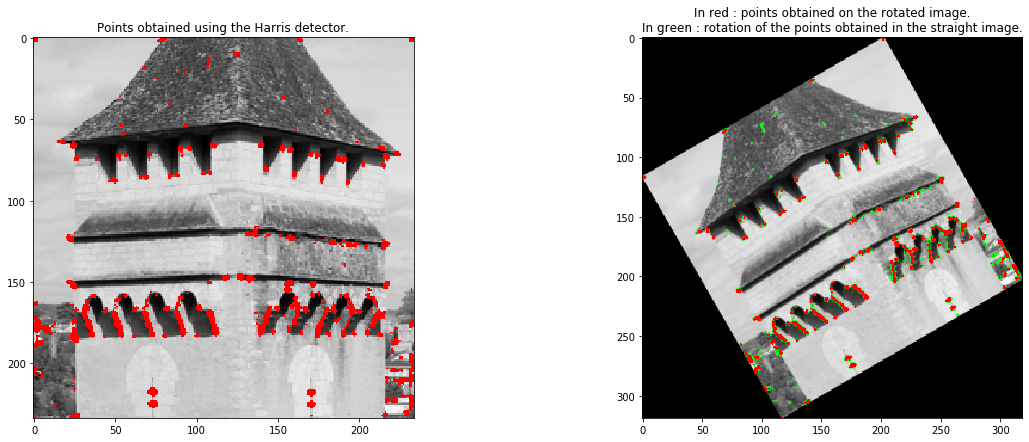

1566 points


In [328]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))

ax1.imshow(img,cmap="gray")
ax1.imshow(point_map(threshold(corner_harris(img),1e7,fixed=True)))
ax1.set_title("Points obtained using the Harris detector.")
#print(threshold(corner_harris(img),0.1).sum(),"points")

ax2.imshow(rotate(img,30,resize=True),cmap="gray")
ax2.imshow(point_map(rotate(threshold(corner_harris(img),1e7,fixed=True),30,resize=True),color=(0,1,0)))
ax2.imshow(point_map(threshold(corner_harris(rotate(img,30,resize=True)),1e7,fixed=True)))
ax2.set_title("In red : points obtained on the rotated image.\nIn green : rotation of the points obtained in the straight image.")
plt.show()
print(threshold(corner_harris(rotate(img,30,resize=True)),1e7,fixed =True).sum(),"points")

## NMS ##

In [377]:
def nms(pts, r=1):
    c = 0.9
    maxmap = np.zeros_like(pts,dtype=int)
    impad = np.zeros((pts.shape[0]+2*r, pts.shape[1]+2*r))
    impad[:,:] = np.NINF
    impad[r:-r,r:-r] = pts
    for (i,j) in np.ndindex(pts.shape):
        maxmap[i,j] = (c * (impad[i:i+2*r+1,j:j+2*r+1]).max() <= pts[i,j])
    return maxmap

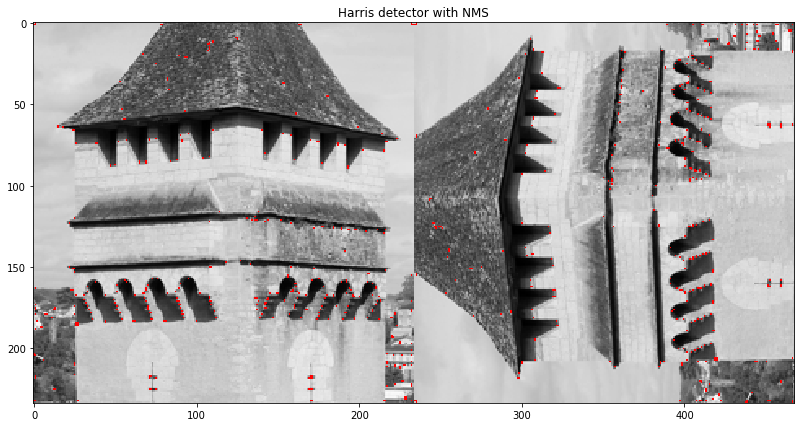

In [378]:
t = 1e7
theta = 90

b = rotate(img, theta)
ba = corner_harris(b)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,b)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros(a.shape,dtype=bool),rotate((nms(a)*threshold(a,t,fixed=True)).astype(float),theta))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((nms(a)*threshold(a,t,fixed=True),nms(ba)*threshold(ba,t,fixed=True)))))

plt.title("Harris detector with NMS")
plt.show()


For this simple transformation the NMS seems to be sufficient to get robustness.

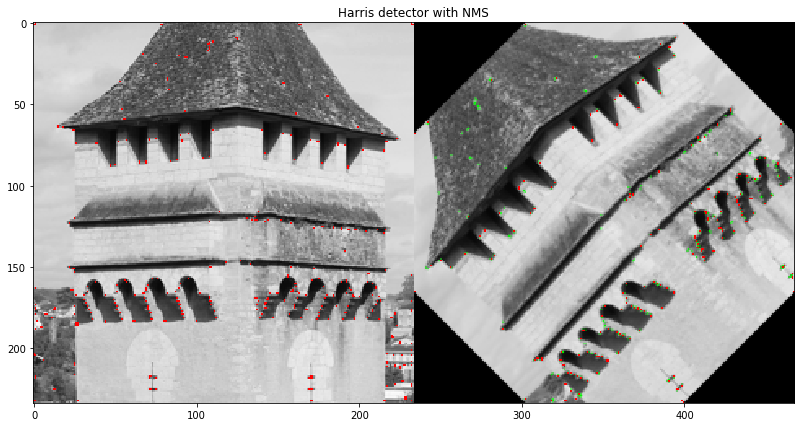

In [379]:
t = 1e7
theta = 45

b = rotate(img, theta)
ba = corner_harris(b)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,b)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros(a.shape,dtype=bool),rotate((nms(a)*threshold(a,t,fixed=True)).astype(float),theta))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((nms(a)*threshold(a,t,fixed=True),nms(ba)*threshold(ba,t,fixed=True)))))

plt.title("Harris detector with NMS")
plt.show()


When we apply scaling and 45 degree rotation NMS does not find the same points in the two images.

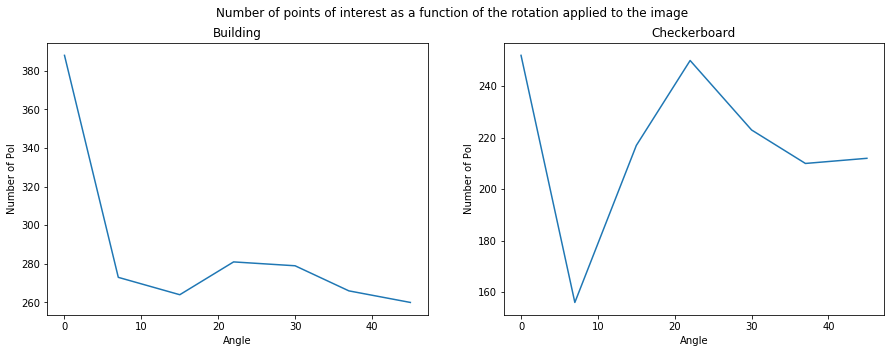

In [380]:
angles = [0,7,15,22,30,37,45]
results = []

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = nms(corners)*threshold(corners,1e7,fixed=True)
    results.append(harris.sum())

sresults = []

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = nms(corners)*threshold(corners,10,fixed=True)
    sresults.append(harris.sum())
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Angle")

plt.show()

Once again the number of detected points changes with the orientation of the image.

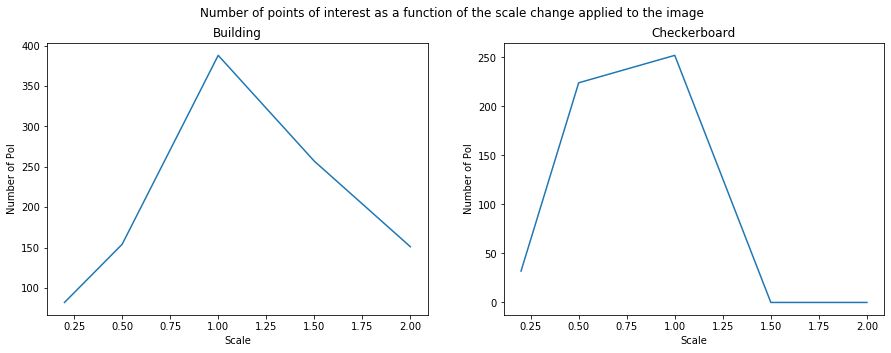

In [388]:
scales = [0.2,0.5,1,1.5,2]

results = []
for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = nms(corners)*threshold(corners,1e7,fixed=True)
    results.append(harris.sum())

sresults = []
for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = nms(corners)*threshold(corners,1e1,fixed=True)
    sresults.append(harris.sum())

    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Scale")

plt.show()

The number of detected points varies with the scale of the image.

## ANMS ##

In [412]:
def anms(correl, n, c=0.9, t = 0.01):
    pts = threshold(correl, t, fixed=False)

    ic = 1/c
    width = pts.shape[1]
    
    detected = [(-correl[i,j],i,j) for i,j in np.ndindex(pts.shape) if pts[i,j]]
    detected.sort()
    detected = np.array(detected)
    
    detected_pos = np.array([[i,j] for _,i,j in detected])
    distances = squareform(pdist(detected_pos, metric='sqeuclidean'))
    npoints = np.arange(len(detected), dtype=int)
    
    rmap = np.zeros_like(correl)
    
    # Process the first point
    _,i,j = detected[0]
    rmap[int(i),int(j)] = - np.inf
    
    for k,(cor,i,j) in enumerate(detected[1:]):
        ccor = ic * cor
        k += 1
        
        bigger_processed = detected[:k,0] < ccor # We store -correl
        bigger_radius = distances[k,:k][bigger_processed]
        if len(bigger_radius) == 0:
            r = np.inf
        else:
            r = bigger_radius.min()
        rmap[int(i),int(j)] = -r
    
    # Extract the n best points
    pos = rmap.reshape(-1).argpartition(n)[:n]
    # Put the n best points in a 2D image
    res = np.zeros_like(pts)
    for p in pos:
        res[p // width, p % width] = True
    return res

In [413]:
aanms = anms(a, 250)
aanmsr = anms(ar, 250)

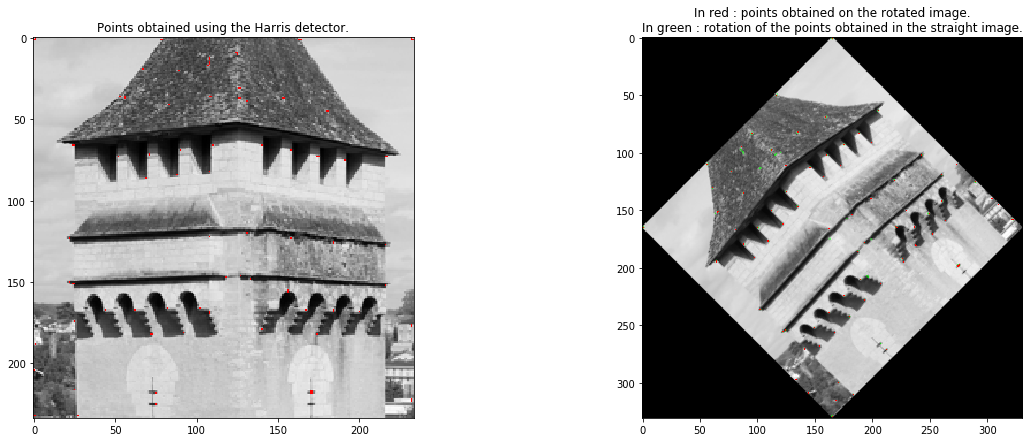

In [423]:
theta = 45
n = 100

b = rotate(img, theta, resize=True)
ba = corner_harris(b)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))

ax1.imshow(img,cmap="gray")
ax1.imshow(point_map(anms(a,n)))
ax1.set_title("Points obtained using the Harris detector.")

ax2.imshow(b,cmap="gray")
ax2.imshow(point_map(rotate(anms(a,n),theta,resize=True),color=(0,1,0)))
ax2.imshow(point_map(anms(ba,n)))
ax2.set_title("In red : points obtained on the rotated image.\nIn green : rotation of the points obtained in the straight image.")
plt.show()


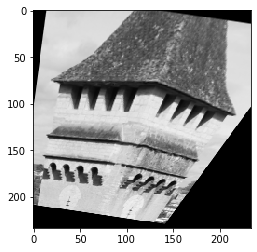

In [461]:
theta = np.pi/12
trsfm = ProjectiveTransform(np.array([[ 0.8+np.cos(theta), -np.sin(theta), 25],
                                      [ np.sin(theta), 1.5+np.cos(theta), -25],
                                      [ 0, 0.005, 1.5]]))
imw = warp(img,trsfm.inverse,preserve_range=False)
plt.imshow(imw,cmap='gray')
plt.show()